In [1]:
import numpy as np
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

plt.rcParams.update({'font.size': 7})

In [2]:
#Takes from recording envs unseen during training:
test_unique = ['georgiatech_bike_14_10',
 'georgiatech_bike_14_12',
 'georgiatech_bike_14_2',
 'georgiatech_bike_14_6',
 'georgiatech_cooking_06_02_2',
 'georgiatech_cooking_06_02_4',
 'georgiatech_cooking_06_03_2',
 'georgiatech_cooking_13_02_2',
 'georgiatech_cooking_13_02_4',
 'minnesota_cooking_010_2',
 'minnesota_cooking_060_2',
 'minnesota_cooking_061_2',
 'nus_cpr_13_1',
 'nus_cpr_13_2',
 'nus_cpr_38_2',
 'nus_cpr_38_3']

In [3]:
takes_file = "/datasets01/egoexo4d/v2/takes.json"
phys_setting_file = "/datasets01/egoexo4d/v2/physical_setting.json"

with open(takes_file, "rb") as f:
    takes = json.load(f)

with open(phys_setting_file, "rb") as f:
    phys_setting = json.load(f)

phys_setting_map = {}
for setting in phys_setting:
    phys_setting_map[setting['physical_uid']] = f"{setting['origin_physical_setting_id']}_{setting['univ_name']}"

take_name_phys_setting_id_map  = {}
for take in takes:
    take_name_phys_setting_id_map[take['take_name']] = take['physical_setting_uid']

In [4]:
def process_data(results, take_to_task_mapping):
    all_data = []
    ious = []
    for res in results:
        narrs = [(n, v_id, c_id) for n_list, v_id, c_id in zip(res['metadata']['narration'], res['metadata']['video_id'], res['metadata']['cam_id']) for n in n_list]
        ious.extend(res['loss_dict'])
        all_data.extend(narrs)
    narrations, video_ids, cam_ids = zip(*all_data)
    data = pd.DataFrame({
        "narration": narrations,
        "iou": ious,
        "video_id": video_ids,
        "camera_id": cam_ids
    })
    data['task_name'] = data['video_id'].map(lambda vid: take_to_task_mapping.get(vid, {}).get('task_name', 'Unknown'))
    data['parent_task_name'] = data['video_id'].map(lambda vid: take_to_task_mapping.get(vid, {}).get('parent_task_name', 'Unknown'))
    return data

def load_and_process_model_data(base_path, model_name, take_to_task_mapping):
    with open(os.path.join(base_path, model_name), "rb") as f:
        results = json.load(f)
    return process_data(results, take_to_task_mapping)

def plot_grouped_bars(grouped_data_list, model_names):
    num_models = len(grouped_data_list)
    bar_width = 0.2
    index = np.arange(len(grouped_data_list[0]))
    plt.figure(figsize=(12, 6))
    
    for i, (grouped_data, model_name) in enumerate(zip(grouped_data_list, model_names)):
        plt.bar(index + i * bar_width, grouped_data['mean'], yerr=grouped_data['std'] / np.sqrt(2379), 
                capsize=5, width=bar_width, label=model_name, alpha=0.7)
    plt.title('Mean IoU Stratified by Task')
    plt.xlabel('Task Name')
    plt.ylabel('Mean IoU')
    plt.xticks(index + bar_width * (num_models - 1) / 2, grouped_data_list[0]['task_name'], rotation=75)
    plt.ylim(0, 0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_narration_differences(df1, df2, model_names, take_to_task_mapping, sampling_rate=10, N=20, save_path=None):
    if not df1.drop(columns='iou').equals(df2.drop(columns='iou')):
        raise ValueError("DataFrames are not identical except for the 'iou' column.")
    # Compute mean IoU by narration for each model
    mean_iou_1 = df1.groupby('narration')['iou'].mean().reset_index()
    mean_iou_2 = df2.groupby('narration')['iou'].mean().reset_index()
    # Merge the mean IoU with the original DataFrame to retain task_name
    mean_iou_1 = mean_iou_1.merge(df1[['narration', 'parent_task_name']].drop_duplicates(), on='narration')
    mean_iou_2 = mean_iou_2.merge(df2[['narration', 'parent_task_name']].drop_duplicates(), on='narration')
    # Merge the dataframes on narration
    merged = pd.merge(mean_iou_1, mean_iou_2, on='narration', suffixes=('_model1', '_model2'))
    merged = merged[(merged['iou_model1'] != 0) | (merged['iou_model2'] != 0)]
    # Compute the difference in mean IoU
    merged['iou_diff'] = merged['iou_model1'] - merged['iou_model2']
    # Sort by the difference
    merged.sort_values(by='iou_diff', ascending=False, inplace=True)
    subsampled = merged.iloc[::sampling_rate]
    extremes = pd.concat([subsampled.head(N), subsampled.tail(N)])
    unique_tasks = extremes['parent_task_name_model1'].unique()
    color_map = {task: plt.cm.tab20(i*2) for i, task in enumerate(unique_tasks)}
    # Plot
    plt.figure(figsize=(14, 8))
    bar_width = 0.2
    index = np.arange(len(extremes))
    plt.bar(index, extremes['iou_diff'], color=[color_map[task] for task in extremes['parent_task_name_model1']], alpha=0.7)
    plt.title('Mean IoU Difference (Ours - EgoVLPv2) by Keystep/Task')
    plt.xlabel('Keystep')
    plt.ylabel('Mean IoU Difference (Ours - EgoVLPv2)')
    plt.xticks(index + bar_width / 2, extremes['narration'], rotation=90)

    ax = plt.gca()
    for tick_label, task_name in zip(ax.get_xticklabels(), extremes['parent_task_name_model1']):
        tick_label.set_color(color_map[task_name])


    legend_patches = [mpatches.Patch(color=color_map[task], label=task) for task in unique_tasks]
    plt.legend(handles=legend_patches, title="Task Names", bbox_to_anchor=(1.05, 1), loc='lower left')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')  # Save with high DPI
    plt.show()

In [5]:
def compute_recall_at_k(data, thresholds=[0.1, 0.3, 0.5, 0.7]):
    # Sort the DataFrame by IoU in descending order
    sorted_data = data.sort_values(by=['iou'], ascending=False)    
    # Compute recall for each threshold
    recall_results = {}
    recalls = []
    for theta in thresholds:
        recall = (sorted_data['iou'] >= theta).mean()
        recall_results[f'IoU>={theta}'] = recall
        recalls.append(recall)
    recall_results['mean IoU'] = np.array(recalls).mean()
    return pd.Series(recall_results)

def compute_recall_at_k_within_scenes(data, phys_setting_map, take_name_phys_setting_id_map, thresholds=[0.1, 0.3, 0.5, 0.7]):
    # Function to compute recall for a single scene
    #data['scene_id'] = data['video_id'].map(lambda x: phys_setting_map[take_name_phys_setting_id_map[x]])
    def compute_recall_for_scene(scene_data):
        # Sort the scene data by IoU in descending order
        sorted_scene_data = scene_data.sort_values(by='iou', ascending=False)
        # Compute recall for each threshold
        recall_results = {}
        recalls = []
        for theta in thresholds:
            recall = (sorted_scene_data['iou'] >= theta).mean()
            recall_results[f'IoU>={theta}'] = recall
            recalls.append(recall)
        recall_results['mean IoU'] = np.array(recalls).mean()
        return pd.Series(recall_results)
    # Group by scene_id and apply the recall calculation
    recall_by_scene = data.groupby('parent_task_name').apply(compute_recall_for_scene)
    return recall_by_scene

In [6]:
with open("/datasets01/egoexo4d/v2/takes.json", "rb") as f:
    takes = json.load(f)
    
# Create the mapping
take_to_task_mapping = {
    item['take_name']: {
        'task_name': item['task_name'],
        'parent_task_name': item['parent_task_name']
    }
    for item in takes
}

In [7]:
base_path = "/private/home/arjunrs1/exo_narration_grounding/ExoGround/train/log"
curr_model_name = "PX_50_200_2024_11_09_00_45_joint_iou_l1_egoexo4d_len64_e6d6_bs16_lr0.0001_view=all_distill=True_pair_ds=False_pair_ds_mode=all_multi_ego=False_narr_rand=False/log/test_results_epoch_54.json" #all: 33, 35, 54, 63 For keystep plot: 54, for seen: 54
#curr_model_name = "/private/home/arjunrs1/exo_narration_grounding/ExoGround/train/log/PX_50_200_2024_11_08_13_21_joint_iou_l1_egoexo4d_len64_e6d6_bs16_lr0.0001_view=all_distill=True_pair_ds=False_pair_ds_mode=all_multi_ego=False_narr_rand=False/log/test_results_epoch_11.json"
vi_model_name = "/private/home/arjunrs1/exo_narration_grounding/ExoGround/train/log/viagain_2024_11_14_06_35_joint_iou_l1_egoexo4d_len64_e6d6_bs16_lr0.0001_view=all_distill=False_pair_ds=False_pair_ds_mode=all_multi_ego=False_narr_rand=False/log/test_results_epoch_35.json"
egovlp_model_name = "/private/home/arjunrs1/exo_narration_grounding/ExoGround/train/log/joint_nodist_b16_2024_10_29_06_36_joint_iou_l1_egoexo4d_len64_e6d6_bs16_lr0.0001_view=all_distill=False_pair_ds=False_pair_ds_mode=all_multi_ego=False_narr_rand=False/log/test_results_epoch_60.json" #all: 31, 38, 43, 47, 53, 57, 59, 60 For keystep plot: 59, for seen: 60
takes_dir = "/datasets01/egoexo4d/v2/takes.json"

model_names = [curr_model_name, egovlp_model_name]
model_short_names = ["Ours", "EgoVLP"]
plots = ["keysteps", 'seen_unseen']

In [8]:
df1 = load_and_process_model_data(base_path, model_names[0], take_to_task_mapping)
df2 = load_and_process_model_data(base_path, model_names[1], take_to_task_mapping)

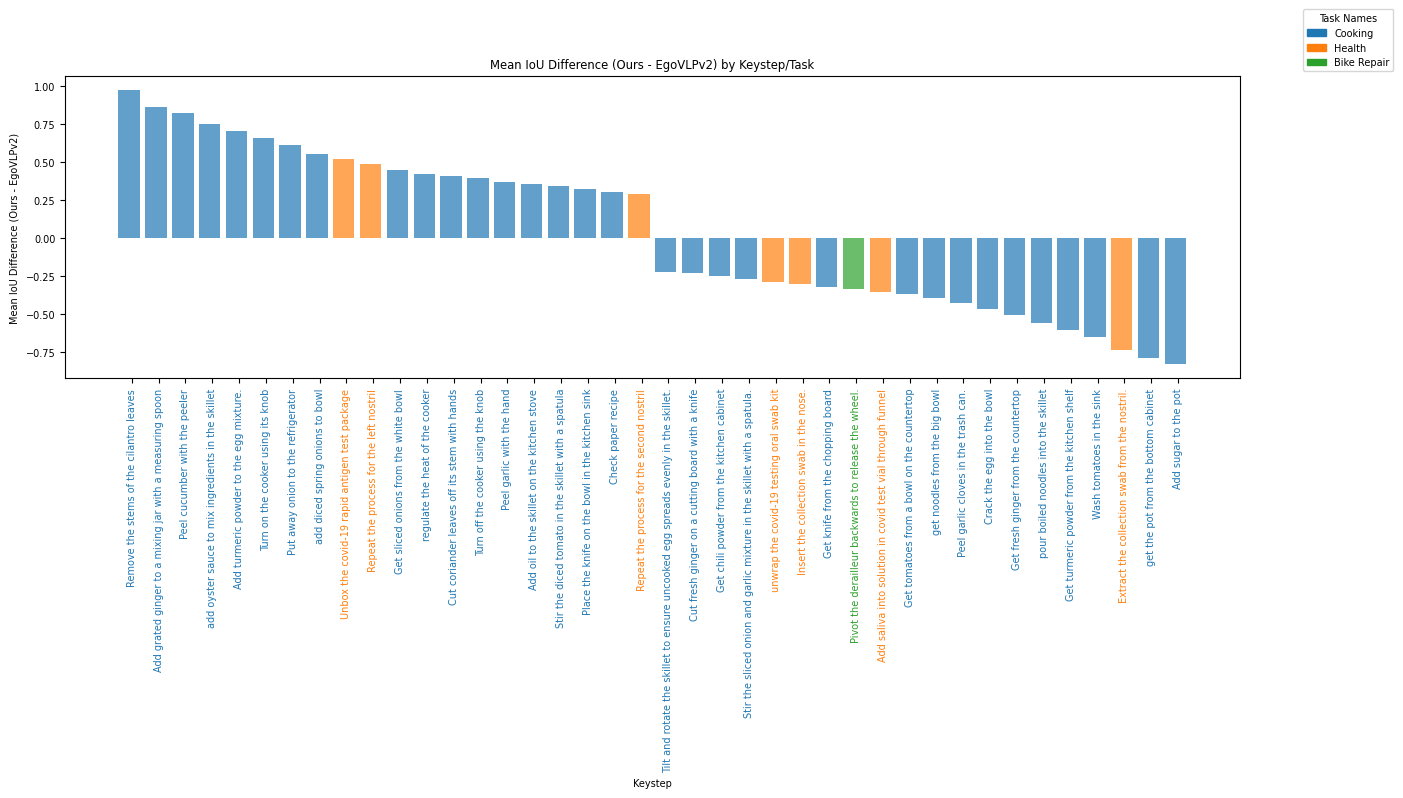

Test-seen (Ours):
IoU>=0.1    0.472658
IoU>=0.3    0.383738
IoU>=0.5    0.283880
IoU>=0.7    0.170233
mean IoU    0.327627
dtype: float64
Test-seen (EgoVLPv2):
IoU>=0.1    0.453638
IoU>=0.3    0.363291
IoU>=0.5    0.263433
IoU>=0.7    0.146457
mean IoU    0.306705
dtype: float64
Test-unseen (Ours):
                  IoU>=0.1  IoU>=0.3  IoU>=0.5  IoU>=0.7  mean IoU
parent_task_name                                                  
Bike Repair       0.571429  0.285714  0.142857  0.071429  0.267857
Cooking           0.501916  0.390805  0.291188  0.187739  0.342912
Test-unseen (EgoVLPv2):
                  IoU>=0.1  IoU>=0.3  IoU>=0.5  IoU>=0.7  mean IoU
parent_task_name                                                  
Bike Repair       0.500000  0.214286  0.142857  0.071429  0.232143
Cooking           0.425287  0.318008  0.260536  0.183908  0.296935


/tmp/ipykernel_2261155/1320920873.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  recall_by_scene = data.groupby('parent_task_name').apply(compute_recall_for_scene)
/tmp/ipykernel_2261155/1320920873.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  recall_by_scene = data.groupby('parent_task_name').apply(compute_recall_for_scene)


In [9]:
if "tasks" in plots:
    # Process data for each model
    grouped_data_list = []
    for model_name in model_names:
        curr_data = load_and_process_model_data(base_path, model_name, take_to_task_mapping)
        grouped_data = curr_data.groupby('task_name')['iou'].agg(['mean', 'std']).reset_index()
        grouped_data_list.append(grouped_data)
    # Plot the results
    plot_grouped_bars(grouped_data_list, model_short_names)
if "keysteps" in plots:
    plot_narration_differences(df1, df2, model_short_names, take_to_task_mapping, save_path="/private/home/arjunrs1/exo_narration_grounding/ExoGround/visualization/keystep_strat.png")
if "seen_unseen" in plots:
    test_seen_df1 = df1[~df1['video_id'].isin(test_unique)]
    test_seen_df2 = df2[~df2['video_id'].isin(test_unique)]
    test_unseen_df1 = df1[df1['video_id'].isin(test_unique)]
    test_unseen_df2 = df2[df2['video_id'].isin(test_unique)]
    print("Test-seen (Ours):")
    print(compute_recall_at_k(test_seen_df1))
    print("Test-seen (EgoVLPv2):")
    print(compute_recall_at_k(test_seen_df2))
    print("Test-unseen (Ours):")
    print(compute_recall_at_k_within_scenes(test_unseen_df1, phys_setting_map, take_name_phys_setting_id_map))
    print("Test-unseen (EgoVLPv2):")
    print(compute_recall_at_k_within_scenes(test_unseen_df2, phys_setting_map, take_name_phys_setting_id_map))